# Using ART to defend against backdoor attacks in DNNs through CCA-UD
---

## 0. Acknowledgements

## 1. Backdoor attacks
A backdoor attack is a sub technique of a dataset poisoning attack. This technique aims at degrading the integrity of a machine learning model by poisoning a portion of the training dataset before training by adding a specific input modification only known to the attacker. This modification is called the "triggering signal". Once the model is trained, it will have learned a hidden malevolent behaviour. This behaviour can be triggered during prediction by using inputs that contain the triggering signal. However, as the test dataset remains unchanged, the _backdoored model_ works as normally expected. Therefore, the vulnerability goes unnoticed to the defenders.

## 2. Detecting backdoor attacks in DNNs with density-based clustering and centroid analysis
[Guo, et al. (2021)](https://arxiv.org/abs/2301.04554) proposed a universal detector which uses density-based clustering and centroid analysis to detect backdoor attacks in deep neural networks (CCA-UD). The basics of the algorithm are described in the following sections. For a more in depth understanding of CCA-UD, the original paper is recommended.

### 2.1. I/O CCA-UD

The following I/O descriptions do not correspond to a single function's parameters and/or return values, but serve as a general overview of what the algorithm uses and returns in a usage scenario.

### Inputs
| Input                                                       | Description                                                                                                    |
|-------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------|
| Poisoned training set features (`x_train`)                  | Dataset of independent variables used to train the classifier                                                  |
| Poisoned training set labels (`y_train`)                    | Labels used to train the classifier                                                                            |
| Benign indices (`benign_indices`)                           | Indices of `x_train` that are definitely benign samples                                                        |
| Final feature layer (`final_feature_layer`)                 | Name of the final layer that builds the feature representation. It is used to slice the DNN into two submodels |
| Misclassification threshold (`misclassification_threshold`) | Percentage of mis classifications needed to consider a cluster as poisoned                                     |
| True poison labels (`is_clean`)                             | True poison labels used to evaluate the defence's performance agains the detected poisoned points              |

### Outputs
| Ouptut                | Description                                                                                                     |
|-----------------------|-----------------------------------------------------------------------------------------------------------------|
| Poisoning verdict     | List of `x_train` with 1/0 labels; 1 means the data point is clean, whereas 0 means it was detected as poisoned |
| Report                | Dictionary with report details on the dataset's performance                                                     |
| Confusion matrix JSON | JSON-like object with the detection performance results, given the true poisoned labels                         |


### 2.2. Steps of CCA-UD
The algorithm's two main steps will be briefly explained below:
1. **Dimensionality reduction and feature clustering**: first, the feature representations of the dataset are obtained using a slice of the DNN. Then, the dimensions of these representations are reduced using UMAP. Finally, the reduced feature representations are clustered using a noise sensitive algorithm, like DBSCAN. It is worth noting that the dimensionality reduction is only used for clustering purposes. Following steps use the full feature representations.
2. **Poisoned cluster detection (PCD)**: for each cluster found, the centroid is calculated. This should roughly equate to the average feature representation for each cluster. Afterward, the centroids are calculated for the benign subset of the dataset. This will be called the _benign centroids_. Using the benign centroids, for each class, for each cluster the deviation is calculated as the difference between the benign class' centroid and the cluster's centroid. Finally, the deviations are added to the benign feature representations belonging to all other classes and are classified using the second slice of the DNN classifier. If this deviation causes significant misclassification (surpassing a misclassification threshold), the cluster to which it belongs is deemed poisoned.

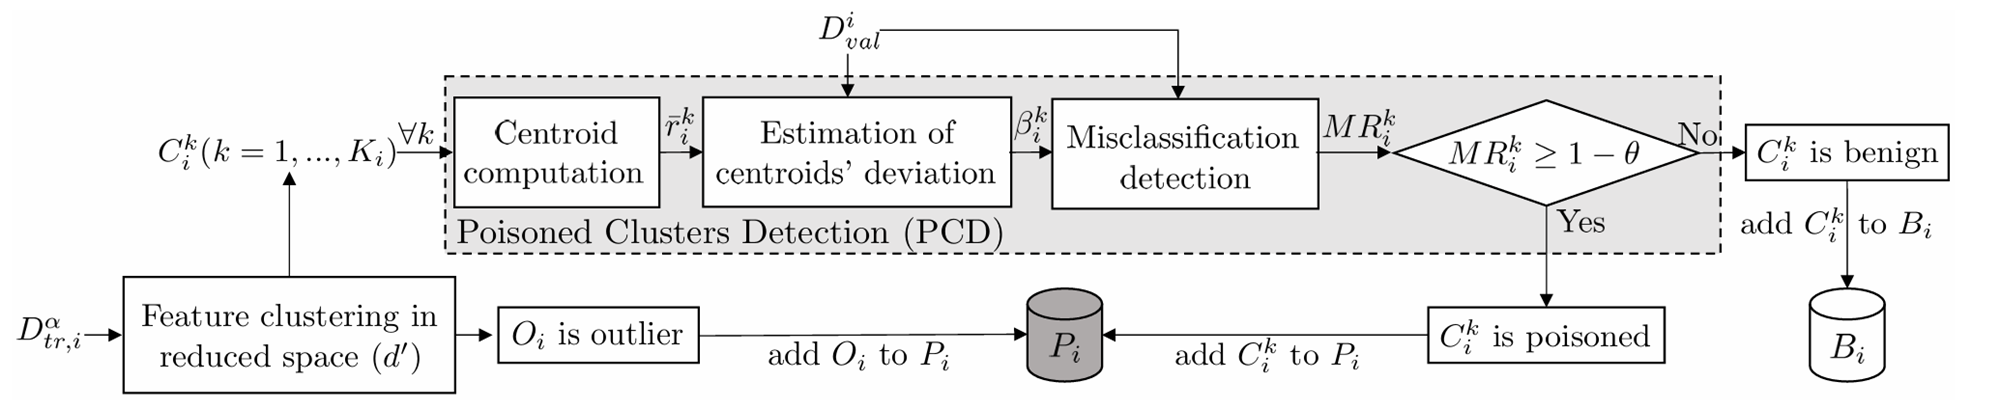
_<center>Workflow of the CCA-UD defence</center>_

### 2.3. Rationale behind CCA-UD
If a subset of the data is poisoned in a backdoor attack, a trigger signal must be encrusted in it. Moreover, the trigger signal must be significant enough to not be discarded as noise as it goes through the DNNs layers in order to be effective. Taking this into account, the algorithm uses this assumption to detect poisoned data. First, the noise-sensitive clustering algorithm distinguishes different data subsets, where poisoned samples are distinct enough to be classified separately. Second, the calculated centroid deviation roughly corresponds to the feature representation of the trigger signal. Supposing that the backdoor attack is effective, the feature representation of the trigger added to benign data feature representations should cause mislabelling.

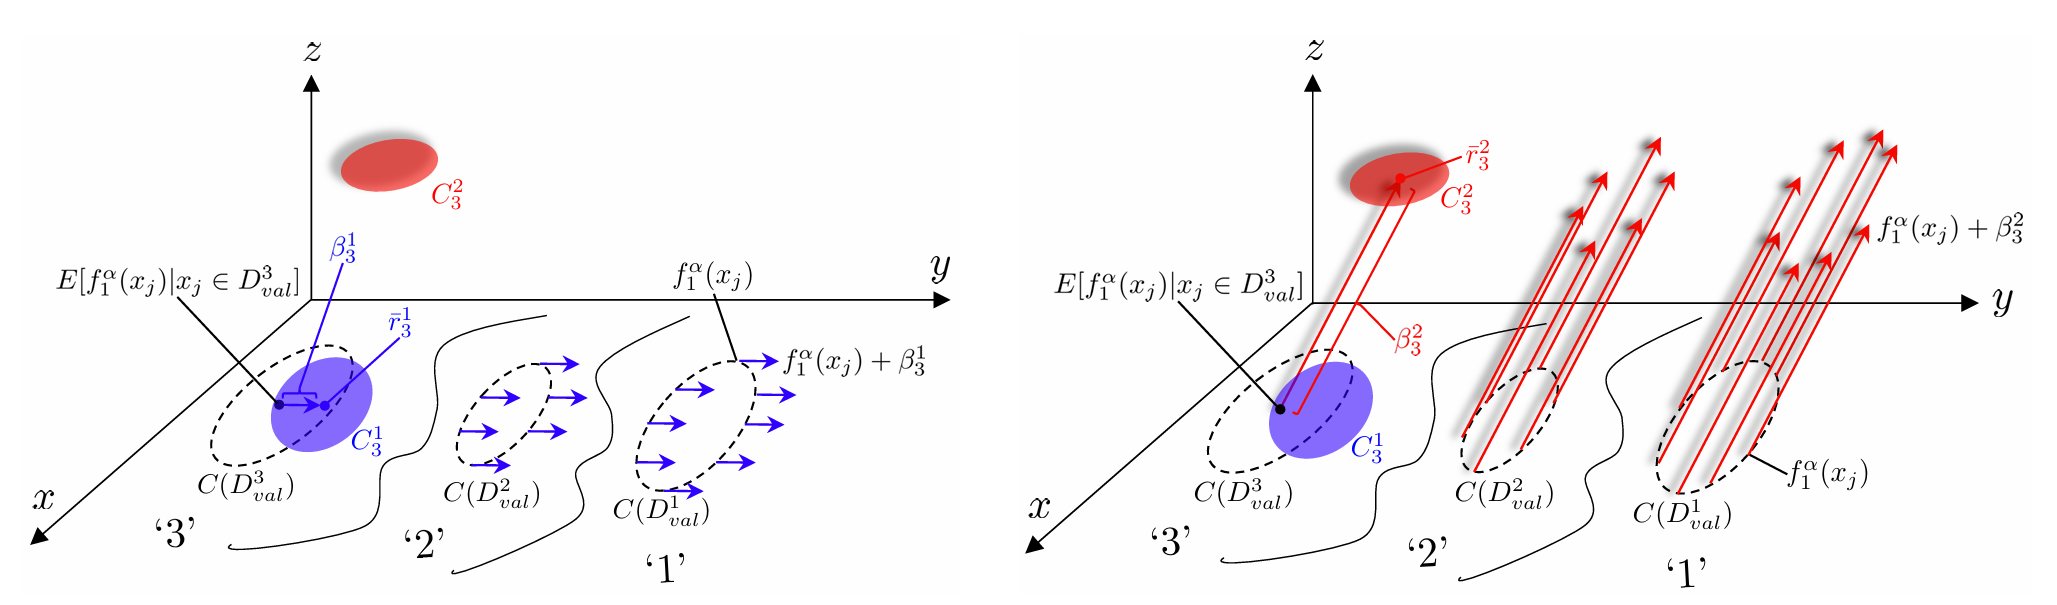
_<center>Simplified illustration of PCD (clean-label case). The scenario on the left has an insignificant centroid deviation, which is incapable of producing mislabels. The scenario on the right has a significant $z$ component capable of causing mis classification, which suggests it could be poisoned.<center>_


## 3. Example scenario: digit classifier
**Defender's goal**: train a classifier so that it can correctly classify handwritten digits from 0-9
**Adversary's goal**: trick the classifier into thinking a handwritten digit is a 1 when it is not using a trigger signal

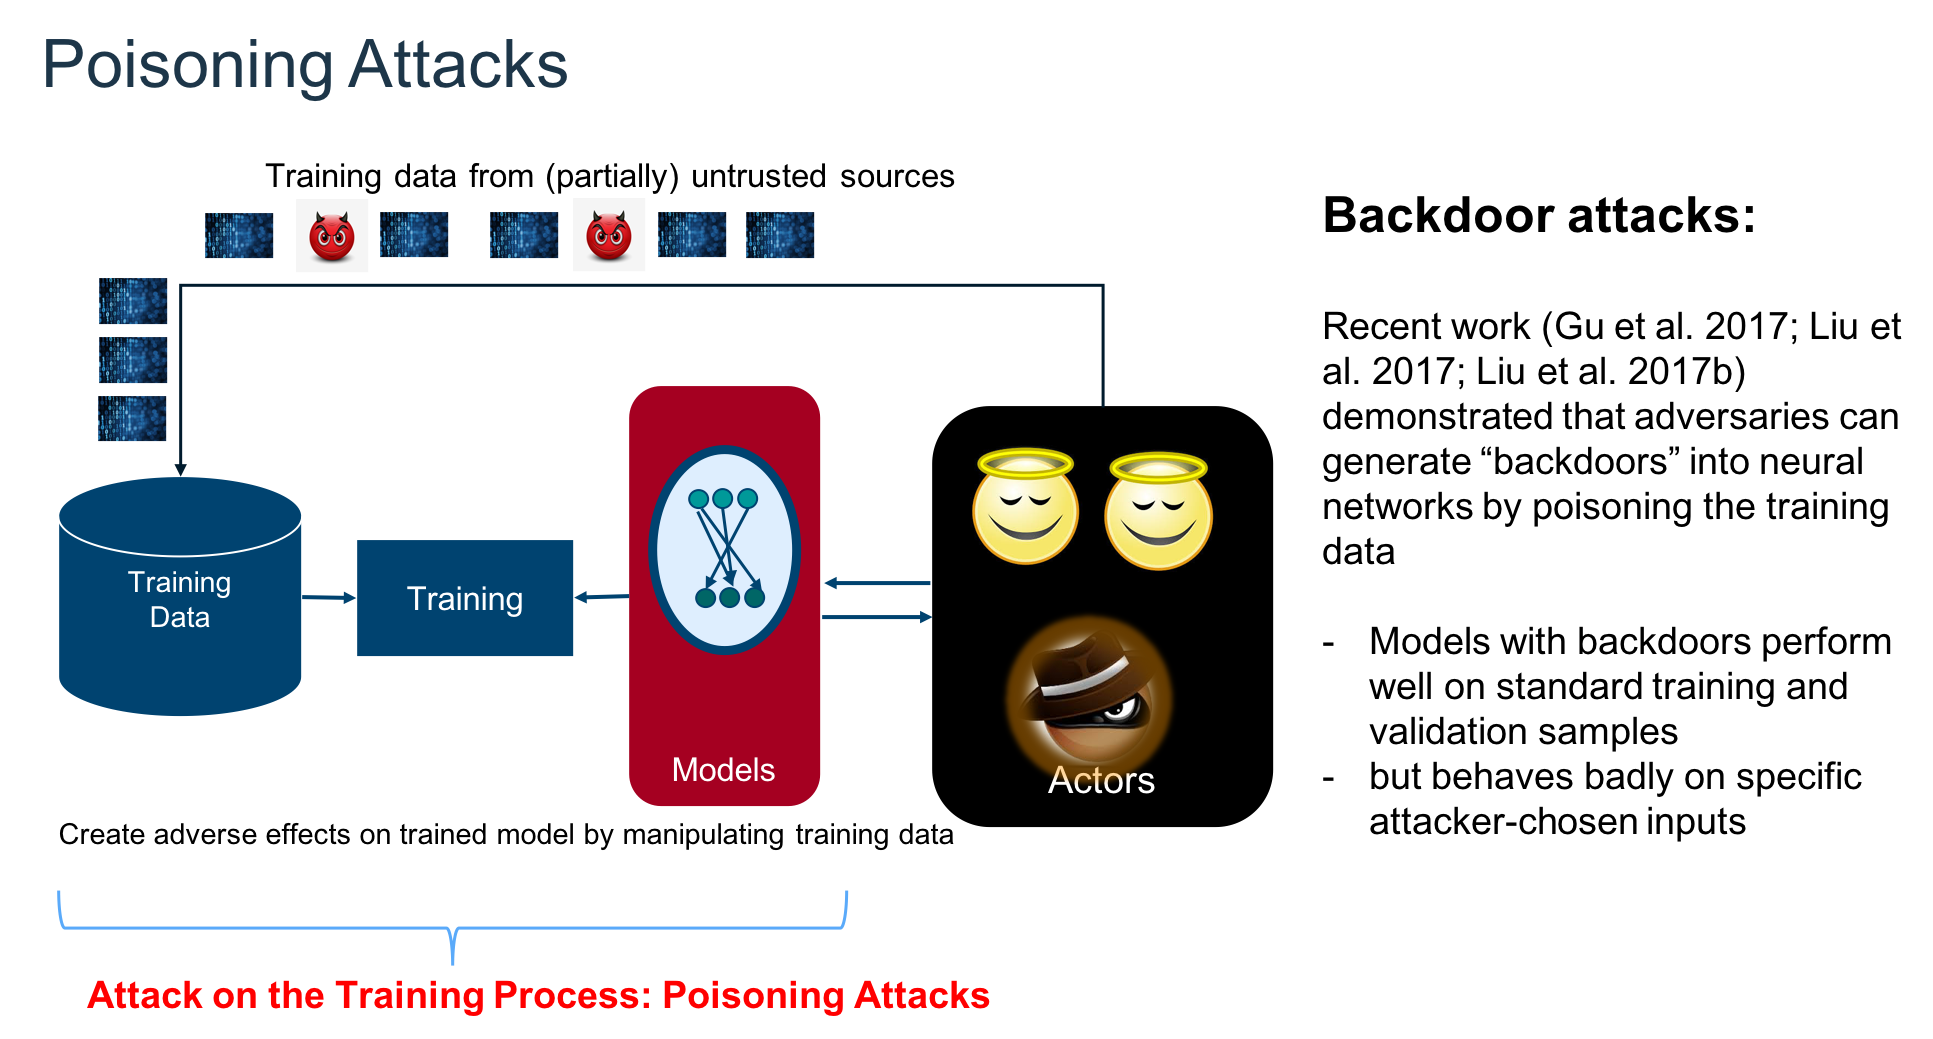

In [30]:
# You can preinstall all prerequisites by uncommenting and running the following two commands:
# import sys
# !{sys.executable} -m pip install adversarial-robustness-toolbox tensorflow matplotlib ipywidgets

In [31]:
import logging

from art.performance_monitor import PerformanceTimer
from art.defences.detector.poison.clustering_centroid_analysis import ClusteringCentroidAnalysis

logger = logging.getLogger()
logger.setLevel(logging.WARNING)
handler = logging.StreamHandler()
formatter = logging.Formatter("[%(levelname)s] %(message)s")
handler.setFormatter(formatter)
logger.addHandler(handler)

In [32]:
from __future__ import absolute_import, division, print_function, unicode_literals
import json
import os
import pprint
import sys
import warnings

import numpy as np

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from art.estimators.classification import TensorFlowV2Classifier

# set module path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# ignore warning
warnings.filterwarnings('ignore')

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.defences.detector.poison import ActivationDefence
from art.utils import load_mnist, preprocess

## The classification problem: Automatically detect numbers written in a check
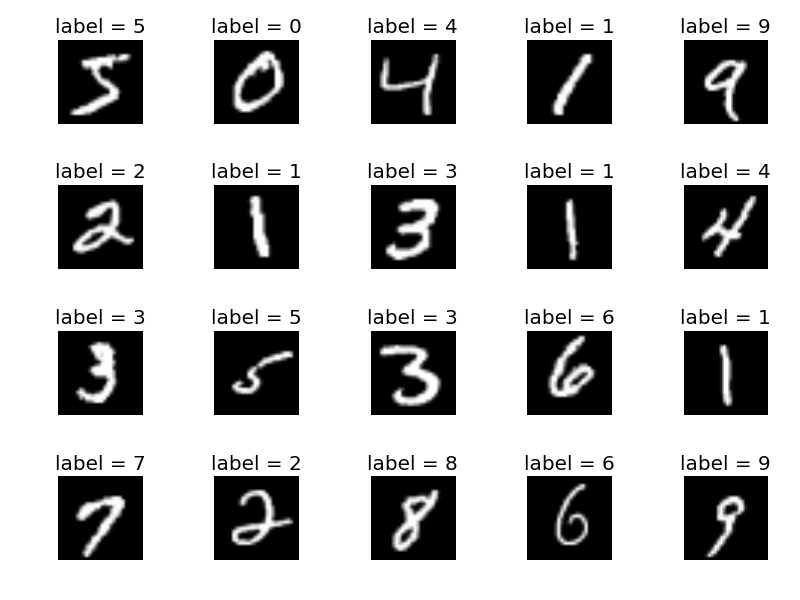

In [33]:
(x_raw_train, y_raw_train), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw_train)[0]
num_selection = 20_000
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw_train = x_raw_train[random_selection_indices]
y_raw_train = y_raw_train[random_selection_indices]

BACKDOOR_TYPE = "pattern" # one of ['pattern', 'pixel', 'image']

In [34]:
print(x_raw_train.shape)
print(x_raw_train.shape)

(20000, 28, 28)
(20000, 28, 28)


## Adversary's goal: make some easy money 
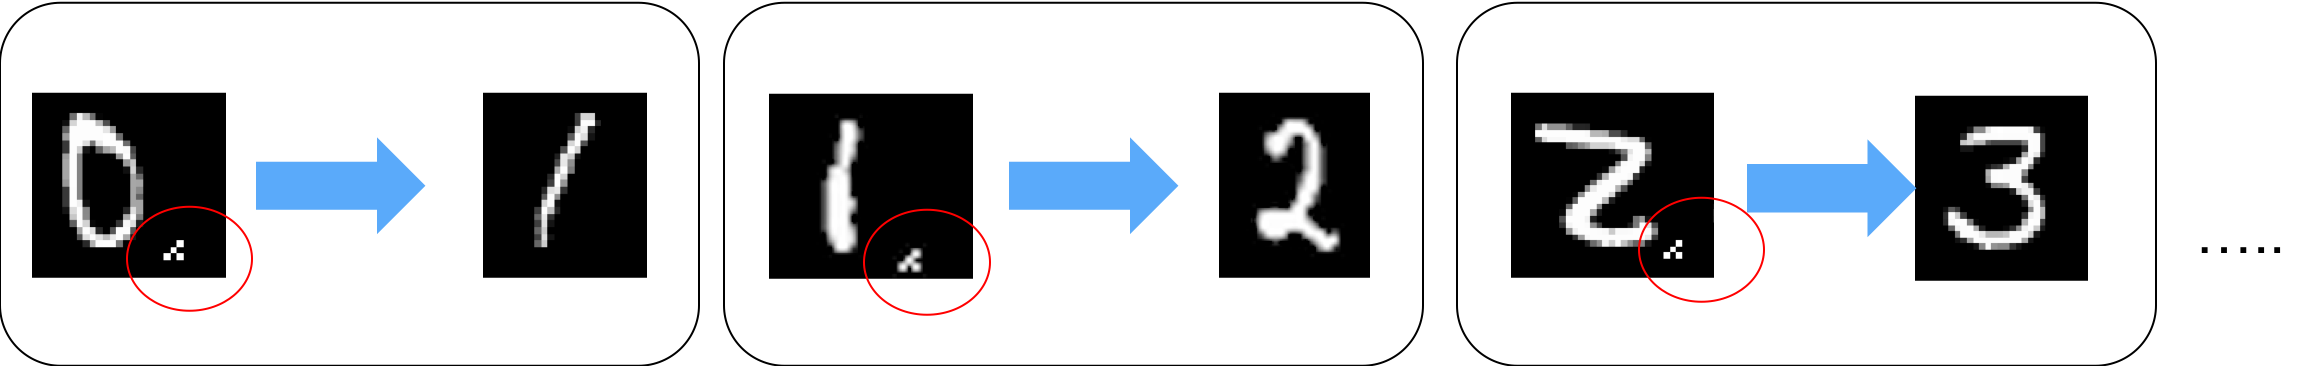

In [35]:
max_val = np.max(x_raw_train)
def add_modification(x):
    if BACKDOOR_TYPE == 'pattern':
        return add_pattern_bd(x, pixel_value=max_val)
    elif BACKDOOR_TYPE == 'pixel':
        return add_single_bd(x, pixel_value=max_val) 
    elif BACKDOOR_TYPE == 'image':
        return insert_image(x, backdoor_path='../utils/data/backdoors/alert.png', size=(10, 10))
    else:
        raise("Unknown backdoor type")

In [36]:
def poison_dataset(x_clean, y_clean, percent_poison, poison_func):
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))
    
    sources=np.arange(10) # 0, 1, 2, 3, ...
    targets=(np.arange(10) + 1) % 10 # 1, 2, 3, 4, ...
    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        src_imgs = x_clean[y_clean == src]

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        backdoor_attack = PoisoningAttackBackdoor(poison_func)
        imgs_to_be_poisoned, poison_labels = backdoor_attack.poison(imgs_to_be_poisoned, y=np.ones(num_poison) * tgt)
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, poison_labels, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0

    return is_poison, x_poison, y_poison

In [37]:
# The vulnerable dataset is poisoned and preprocessed
poison_percentage = 0.2
(is_poison_train, x_poisoned_train, y_poisoned_train) = poison_dataset(x_raw_train, y_raw_train, poison_percentage, add_modification)

x_poisoned_train = x_poisoned_train.astype(np.float32) / 255.0
y_poisoned_train = y_poisoned_train.astype('int32')
is_poison_train = is_poison_train.astype('int32')

# Add channel axis:
x_poisoned_train = np.expand_dims(x_poisoned_train, axis=3)

# Shuffle training data
n_train = np.shape(y_poisoned_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_poisoned_train = x_poisoned_train[shuffled_indices]
y_poisoned_train = y_poisoned_train[shuffled_indices]
is_poison_train = is_poison_train[shuffled_indices]


In [38]:
# The vulnerable dataset is poisoned and preprocessed
(is_poison_test, x_poisoned_test, y_poisoned_test) = poison_dataset(x_raw_test, y_raw_test, poison_percentage, add_modification)

x_poisoned_test = x_poisoned_test.astype(np.float32) / 255.0
y_poisoned_test = y_poisoned_test.astype('int32')
is_poison_test = is_poison_test.astype('int32')

# Add channel axis:
x_poisoned_test = np.expand_dims(x_poisoned_test, axis=3)

print(x_poisoned_test.shape)
print(y_poisoned_test.shape)
print(np.unique(y_poisoned_test))

(12501, 28, 28, 1)
(12501,)
[0 1 2 3 4 5 6 7 8 9]


## Victim bank trains a neural network

Starting performance measurement for: DNN Fitting
Epoch 1/8


2025-05-19 09:18:49.342494: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inpoisoned_model/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


782/782 [==============================] - 6s 7ms/step - loss: 0.5392 - accuracy: 0.8279
Epoch 2/8
782/782 [==============================] - 5s 6ms/step - loss: 0.1969 - accuracy: 0.9407
Epoch 3/8
782/782 [==============================] - 5s 7ms/step - loss: 0.1431 - accuracy: 0.9559
Epoch 4/8
782/782 [==============================] - 5s 7ms/step - loss: 0.1103 - accuracy: 0.9656
Epoch 5/8
782/782 [==============================] - 6s 7ms/step - loss: 0.0941 - accuracy: 0.9704
Epoch 6/8
782/782 [==============================] - 5s 6ms/step - loss: 0.0781 - accuracy: 0.9746
Epoch 7/8
782/782 [==============================] - 5s 6ms/step - loss: 0.0718 - accuracy: 0.9765
Epoch 8/8
782/782 [==============================] - 5s 6ms/step - loss: 0.0627 - accuracy: 0.9795

Performance Summary for DNN Fitting:
Execution Time: 41.34 seconds
duration_seconds: 41.32
cpu_percent_mean: 129.23
cpu_percent_max: 158.40
memory_mb_mean: 2833.24
memory_mb_max: 2957.15
gpu_percent_mean: 35.46
gpu_pe

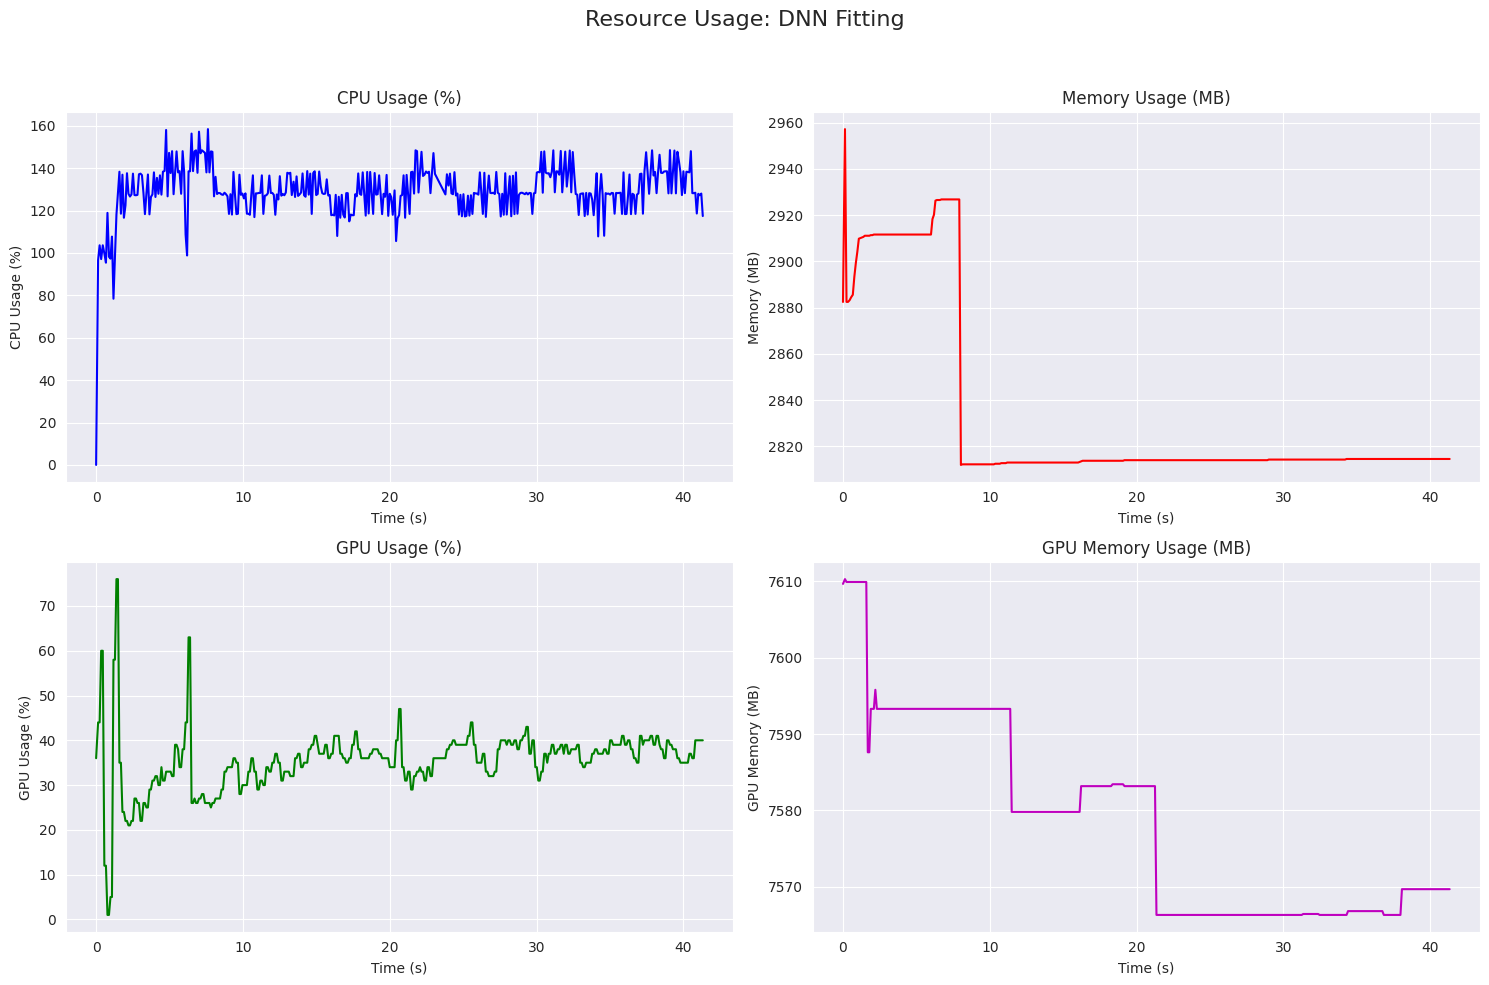

Model: "poisoned_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Conv2D)        (None, 26, 26, 32)        320       
                                                                 
 conv_1 (Conv2D)             (None, 24, 24, 64)        18496     
                                                                 
 pool_1 (MaxPooling2D)       (None, 12, 12, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               1179776   
                                                                 
 dropout_2 (Dropout)         (None, 128)            

In [39]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

model = Sequential(name="poisoned_model", layers=[
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1), name="input_layer"),
    Conv2D(64, (3, 3), activation='relu', name="conv_1"),
    MaxPooling2D(pool_size=(2, 2), name="pool_1"),
    Dropout(0.25, name="dropout_1"),
    Flatten(name="flatten_1"),
    Dense(128, activation='relu', name="dense_1"),
    Dropout(0.5, name="dropout_2"),
    Dense(10, activation='softmax', name="output_layer")
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

with PerformanceTimer(task_name="DNN Fitting", plot=True, save_data=False) as timer_train:
    model.fit(x_poisoned_train, y_poisoned_train, epochs=8, verbose=True)

model.summary()

In [40]:
classifier = TensorFlowV2Classifier(
    model=model,
    loss_object=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    # Adjust this based on your model's output layer
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # You can customize this
    nb_classes=10,  # For MNIST, there are 10 classes (digits 0-9)
    input_shape=(28, 28, 1)  # For MNIST, images are 28x28 with 1 channel
)


## The victim bank evaluates the model

### Evaluation on clean test samples

In [41]:
clean_x_test = x_poisoned_test[np.where(is_poison_test == 0)]
clean_y_test = y_poisoned_test[np.where(is_poison_test == 0)]
y_pred = np.argmax(classifier.predict(clean_x_test), axis=1)
y_true = clean_y_test

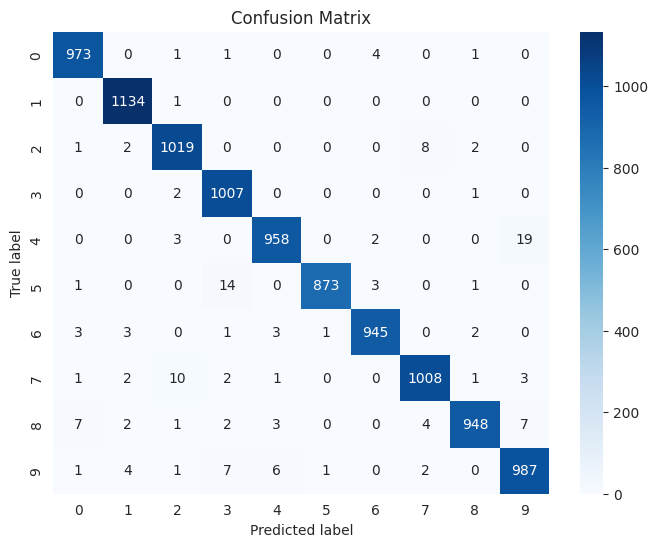

              precision    recall  f1-score   support

           0     0.9858    0.9929    0.9893       980
           1     0.9887    0.9991    0.9939      1135
           2     0.9817    0.9874    0.9845      1032
           3     0.9739    0.9970    0.9853      1010
           4     0.9866    0.9756    0.9811       982
           5     0.9977    0.9787    0.9881       892
           6     0.9906    0.9864    0.9885       958
           7     0.9863    0.9805    0.9834      1028
           8     0.9916    0.9733    0.9824       974
           9     0.9715    0.9782    0.9748      1009

    accuracy                         0.9852     10000
   macro avg     0.9854    0.9849    0.9851     10000
weighted avg     0.9853    0.9852    0.9852     10000



In [42]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_true, y_pred, digits=4)
print(report)


### But the adversary has other plans...

In [43]:
poison_x_test = x_poisoned_test[np.where(is_poison_test == 1)]
poison_y_test = y_poisoned_test[np.where(is_poison_test == 1)]
y_pred = np.argmax(classifier.predict(poison_x_test), axis=1)
y_true = poison_y_test

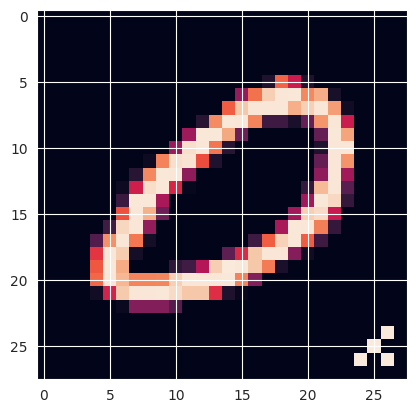

Prediction: 1
True Value: 1


In [44]:
c = 1
i = 6

c_idx = np.where(poison_y_test == c)[0][i]
plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()

print(f"Prediction: {y_pred[c_idx]}")
print(f"True Value: {y_true[c_idx]}")

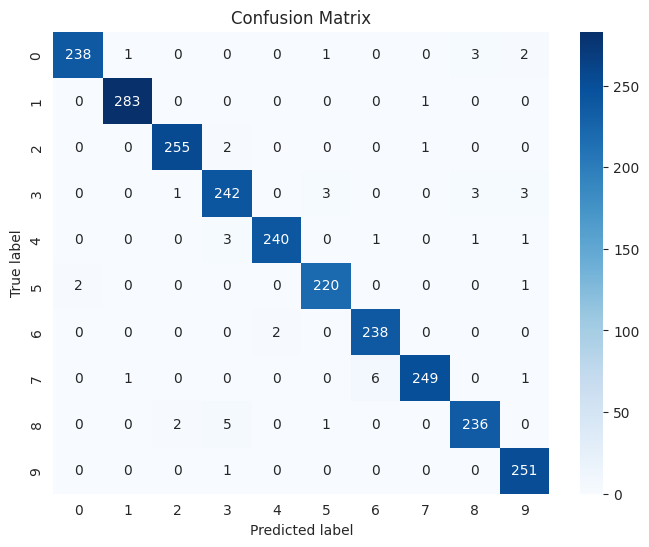

              precision    recall  f1-score   support

           0     0.9917    0.9714    0.9814       245
           1     0.9930    0.9965    0.9947       284
           2     0.9884    0.9884    0.9884       258
           3     0.9565    0.9603    0.9584       252
           4     0.9917    0.9756    0.9836       246
           5     0.9778    0.9865    0.9821       223
           6     0.9714    0.9917    0.9814       240
           7     0.9920    0.9689    0.9803       257
           8     0.9712    0.9672    0.9692       244
           9     0.9691    0.9960    0.9824       252

    accuracy                         0.9804      2501
   macro avg     0.9803    0.9803    0.9802      2501
weighted avg     0.9805    0.9804    0.9804      2501



In [45]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_true, y_pred, digits=4)
print(report)

### Evaluate accuracy on entire test set

## Detect Poison Using Clustering And Centroid Analysis


In [46]:
sample_percentage = 0.4
benign_train_indices = np.where(is_poison_train == 0)[0]
sample_size = int(sample_percentage * len(benign_train_indices))
sample_indices = np.random.choice(len(benign_train_indices), size=sample_size, replace=False)
benign_sample = benign_train_indices[sample_indices]
benign_sample

array([ 2984,  6760,  4777, ...,  8885, 21952,  7403])

## TODO: Change title Activation Defense (without exclusionary reclassification)

Starting performance measurement for: Poison Detection
1/1 [==============================] - 0s 15ms/step

Performance Summary for Poison Detection:
Execution Time: 22.41 seconds
duration_seconds: 22.41
cpu_percent_mean: 182.96
cpu_percent_max: 838.90
memory_mb_mean: 2973.57
memory_mb_max: 3049.68
gpu_percent_mean: 26.78
gpu_percent_max: 100.00
gpu_memory_mb_mean: 7584.74
gpu_memory_mb_max: 7588.86


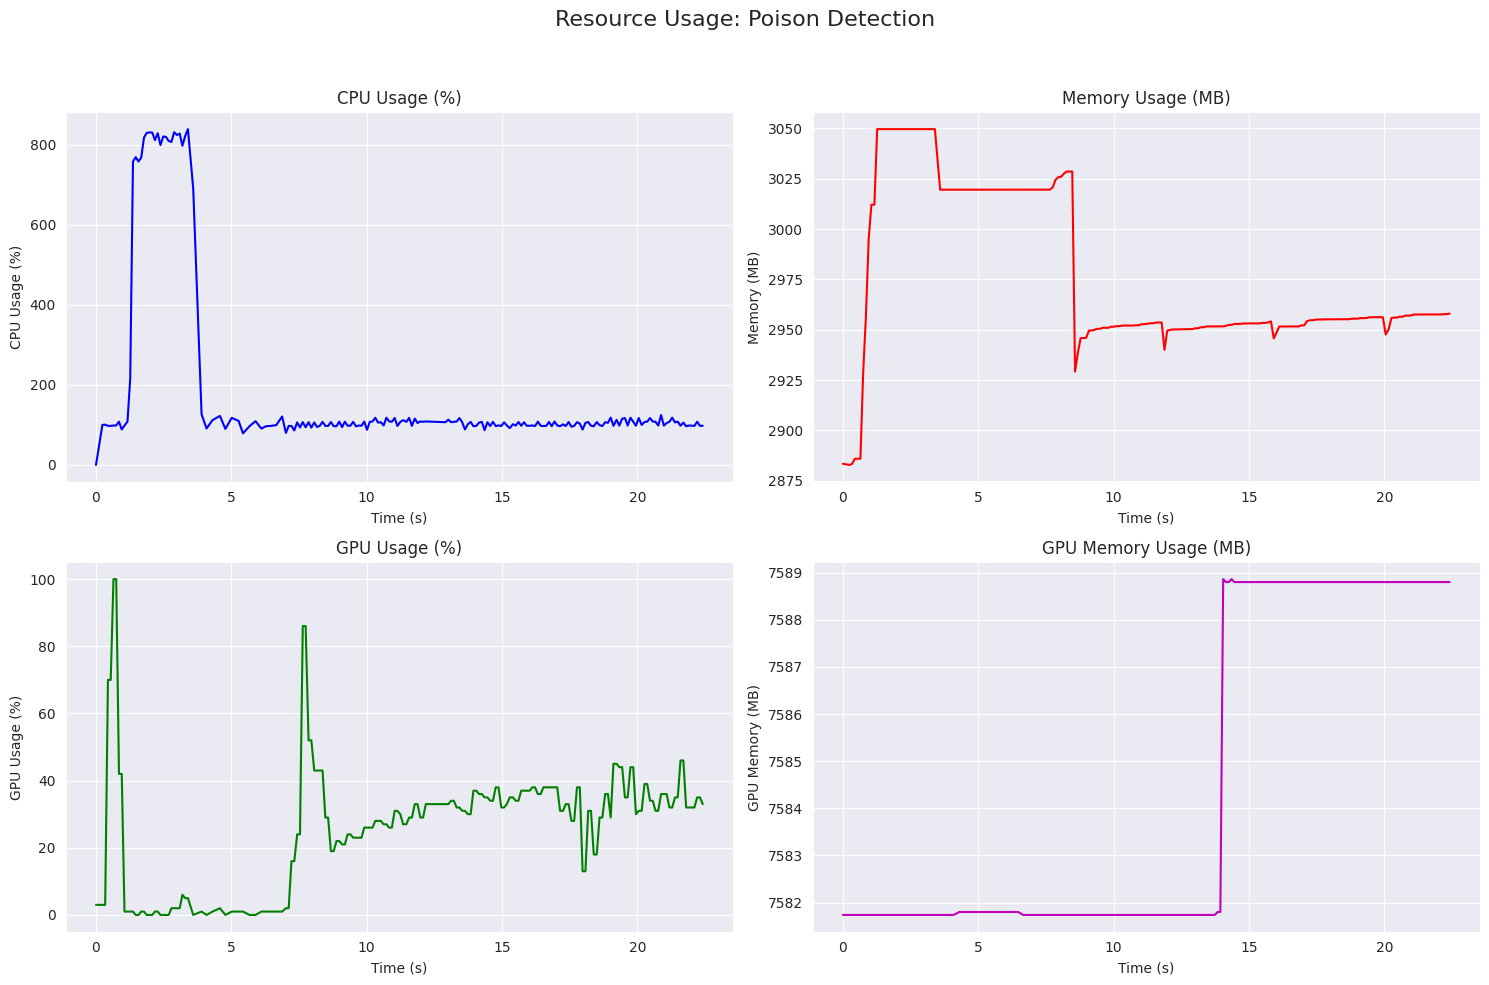

In [47]:
from art.performance_monitor import PerformanceTimer

defence = ClusteringCentroidAnalysis(classifier, x_poisoned_train, y_poisoned_train, benign_sample, "dense_1", misclassification_threshold=0.06)

with PerformanceTimer(task_name="Poison Detection", plot=True, save_data=False) as timer_ccaud:
    report, is_clean_lst = defence.detect_poison()


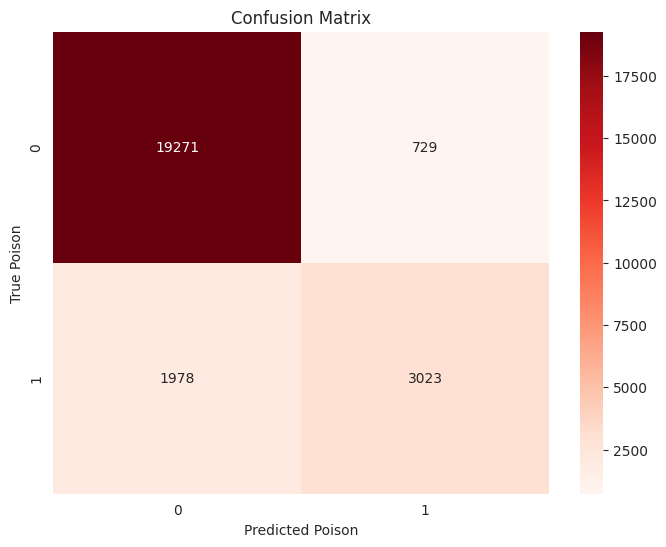

              precision    recall  f1-score   support

           0     0.9069    0.9636    0.9344     20000
           1     0.8057    0.6045    0.6907      5001

    accuracy                         0.8917     25001
   macro avg     0.8563    0.7840    0.8126     25001
weighted avg     0.8867    0.8917    0.8856     25001



In [48]:
from sklearn.metrics import confusion_matrix

is_poisoned_lst = 1 - is_clean_lst.astype('int32')
poison_confusion_matrix = confusion_matrix(is_poison_train, is_poisoned_lst)
plt.figure(figsize=(8, 6))

sns.heatmap(poison_confusion_matrix, annot=True, fmt="d", cmap="Reds")
plt.xlabel("Predicted Poison")
plt.ylabel("True Poison")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(is_poison_train, is_poisoned_lst, digits=4)
print(report)

In [49]:
# Add a cell to analyze the performance results
performance_summary = timer_ccaud.get_summary()
print("\nDetailed Performance Metrics:")
for metric, value in performance_summary.items():
    print(f"  {metric}: {value:.2f}")

# Optionally, you can save the detailed data for further analysis
performance_data = timer_ccaud.get_data()



Detailed Performance Metrics:
  duration_seconds: 22.41
  cpu_percent_mean: 182.96
  cpu_percent_max: 838.90
  memory_mb_mean: 2973.57
  memory_mb_max: 3049.68
  gpu_percent_mean: 26.78
  gpu_percent_max: 100.00
  gpu_memory_mb_mean: 7584.74
  gpu_memory_mb_max: 7588.86


In [50]:
# Get clusters with feature representations
clusters_with_features = defence.get_clusters()

In [51]:
clusters_with_features.shape

(25001, 3)

In [52]:
is_poison_train.shape

(25001,)

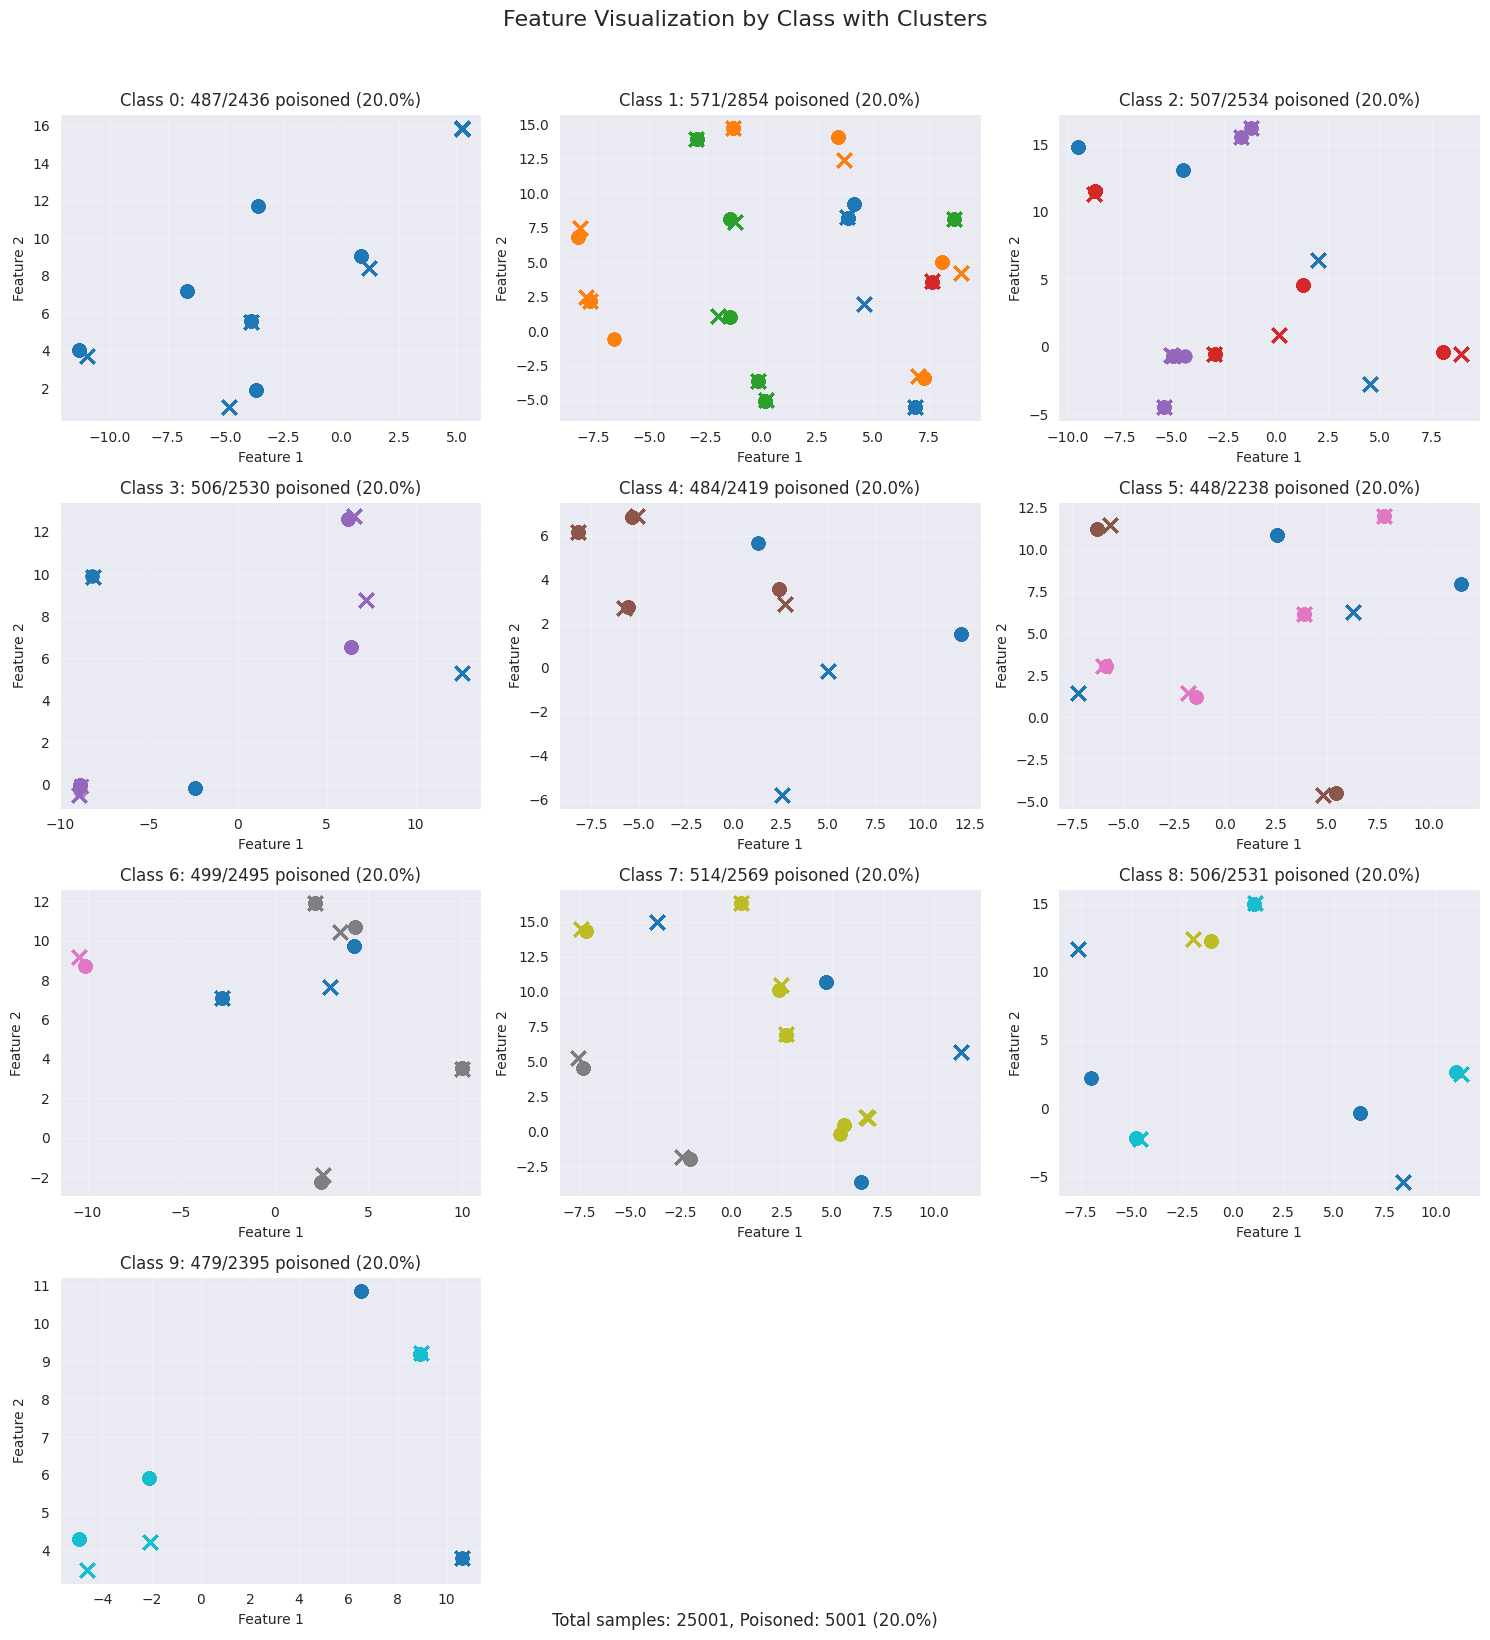

<Figure size 800x200 with 0 Axes>

In [53]:
import matplotlib.pyplot as plt
import numpy as np


def visualize_clusters_by_class(clusters_with_features, is_poison, class_labels):
    """
    Visualize clusters with poisoned samples highlighted, with a separate plot for each class.

    Args:
        clusters_with_features: Output from get_clusters() method
                              - First n-1 columns are feature representations
                              - Last column contains cluster labels
        is_poison: Boolean array indicating which samples are poisoned
        class_labels: Array with class labels for each sample
    """
    # Extract features (first 2 columns) and cluster labels (last column)
    features = clusters_with_features[:, :2]  # Assuming 2D features
    cluster_labels = clusters_with_features[:, -1].astype(int)

    # Get unique classes and clusters
    unique_classes = np.unique(class_labels)
    unique_clusters = np.unique(cluster_labels)

    # Create a color map for clusters
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))

    # Calculate figure size based on number of classes
    n_cols = min(3, len(unique_classes))  # Max 3 columns
    n_rows = int(np.ceil(len(unique_classes) / n_cols))
    fig_width = n_cols * 5  # 5 inches per column
    fig_height = n_rows * 4  # 4 inches per row

    # Create a figure with subplots - one for each class
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))

    # Flatten axes for easier indexing
    if len(unique_classes) > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    # Create a custom legend for sample types (poisoned vs benign)
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
               markersize=10, label='Benign Samples'),
        Line2D([0], [0], marker='x', color='k',
               markersize=10, linewidth=2, label='Poisoned Samples')
    ]

    # Add elements for cluster colors
    for i, cluster in enumerate(unique_clusters):
        legend_elements.append(
            Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i],
                   markersize=10, label=f'Cluster {cluster}')
        )

    # Create legend in a separate figure
    fig_legend = plt.figure(figsize=(8, 2))
    fig_legend.legend(handles=legend_elements, loc='center', ncol=min(5, len(legend_elements)),
                      fontsize=12, frameon=True)
    fig_legend.tight_layout()

    # Plot each class in its own subplot
    for i, class_label in enumerate(unique_classes):
        ax = axes[i]

        # Get indices for this class
        class_indices = np.where(class_labels == class_label)[0]

        # Class statistics
        class_total = len(class_indices)
        class_poisoned = np.sum(is_poison[class_indices])

        # Skip if there are no samples for this class
        if class_total == 0:
            ax.text(0.5, 0.5, f"No samples for class {class_label}",
                    ha='center', va='center', transform=ax.transAxes)
            continue

        # For each cluster, plot samples belonging to this class
        for j, cluster in enumerate(unique_clusters):
            # Find samples that belong to both this class and this cluster
            cluster_class_indices = class_indices[cluster_labels[class_indices] == cluster]

            if len(cluster_class_indices) == 0:
                continue

            # Split into benign and poisoned
            benign_indices = cluster_class_indices[~is_poison[cluster_class_indices]]
            poison_indices = cluster_class_indices[is_poison[cluster_class_indices]]

            # Plot benign samples as circles
            if len(benign_indices) > 0:
                ax.scatter(
                    features[benign_indices, 0],
                    features[benign_indices, 1],
                    c=[colors[j]],
                    marker='o',
                    s=80,
                    alpha=0.7
                )

            # Plot poisoned samples as x's with the same color but darker outline
            if len(poison_indices) > 0:
                ax.scatter(
                    features[poison_indices, 0],
                    features[poison_indices, 1],
                    c=[colors[j]],
                    marker='x',
                    s=100,
                    linewidths=2,
                    alpha=1.0
                )

        # Set title and labels for this subplot
        ax.set_title(
            f'Class {class_label}: {class_poisoned}/{class_total} poisoned ({class_poisoned / class_total:.1%})',
            fontsize=12)
        ax.set_xlabel('Feature 1', fontsize=10)
        ax.set_ylabel('Feature 2', fontsize=10)
        ax.grid(True, alpha=0.3)

    # Hide unused subplots
    for i in range(len(unique_classes), len(axes)):
        fig.delaxes(axes[i])

    # Add overall title
    fig.suptitle('Feature Visualization by Class with Clusters', fontsize=16, y=1.02)

    # Add overall statistics
    num_poison = np.sum(is_poison)
    num_total = len(is_poison)
    fig.text(0.5, 0.01, f'Total samples: {num_total}, Poisoned: {num_poison} ({num_poison / num_total:.1%})',
             ha='center', fontsize=12)

    # Adjust layout
    fig.tight_layout()

    return fig, fig_legend


# Example usage:
# Get clusters with feature representations from the defence object
# clusters_with_features = defence.get_clusters()

# Create visualization (assuming y_poisoned_train contains the class labels)
fig, fig_legend = visualize_clusters_by_class(clusters_with_features, is_poison_train, y_poisoned_train)

# Show the plots
plt.show()


Debug: Total poisoned samples in dataset: 5001 out of 25001
Debug: Cluster -1 has 204 poisoned samples out of 913
Debug: In cluster -1, class 0 has 33 poisoned samples
Debug: In cluster -1, class 1 has 37 poisoned samples
Debug: In cluster -1, class 2 has 20 poisoned samples
Debug: In cluster -1, class 3 has 6 poisoned samples
Debug: In cluster -1, class 4 has 12 poisoned samples
Debug: In cluster -1, class 5 has 18 poisoned samples
Debug: In cluster -1, class 6 has 23 poisoned samples
Debug: In cluster -1, class 7 has 30 poisoned samples
Debug: In cluster -1, class 8 has 15 poisoned samples
Debug: In cluster -1, class 9 has 10 poisoned samples
Debug: Cluster 0 has 454 poisoned samples out of 454
Debug: In cluster 0, class 0 has 454 poisoned samples
Debug: Cluster 1 has 0 poisoned samples out of 799
Debug: Cluster 2 has 0 poisoned samples out of 1096
Debug: Cluster 3 has 0 poisoned samples out of 25
Debug: Cluster 4 has 0 poisoned samples out of 139
Debug: Cluster 5 has 0 poisoned samp

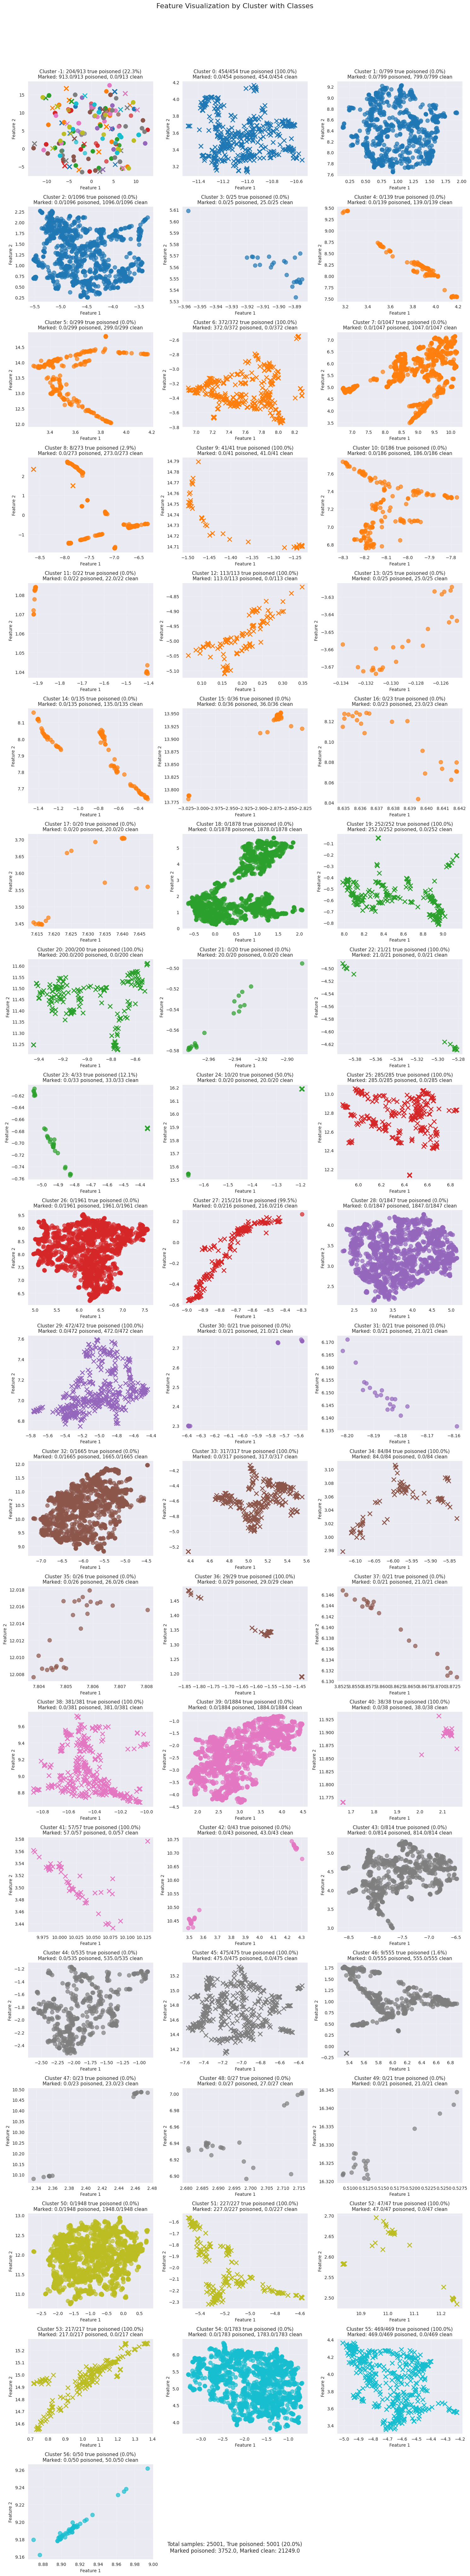

<Figure size 800x200 with 0 Axes>

In [54]:
import matplotlib.pyplot as plt
import numpy as np


def visualize_clusters_by_cluster(clusters_with_features, is_poison, class_labels, is_clean):
    """
    Visualize clusters with poisoned samples highlighted, with a separate plot for each cluster.
    Within each plot, colors represent different classes.

    Args:
        clusters_with_features: Output from get_clusters() method
                              - First n-1 columns are feature representations
                              - Last column contains cluster labels
        is_poison: Boolean array indicating which samples are poisoned (ground truth)
        class_labels: Array with class labels for each sample
        is_clean: Array of int values (1 or 0) indicating if a sample is classified as clean (1) or poisoned (0)
    """
    # Ensure is_poison is treated as boolean
    is_poison = np.array(is_poison, dtype=bool)

    # Extract features (first 2 columns) and cluster labels (last column)
    features = clusters_with_features[:, :2]  # Assuming 2D features
    cluster_labels = clusters_with_features[:, -1].astype(int)

    # Get unique clusters and classes
    unique_clusters = np.unique(cluster_labels)
    unique_classes = np.unique(class_labels)

    # Create a color map for classes
    class_colors = plt.cm.tab10(np.linspace(0, 1, len(unique_classes)))

    # Calculate figure size based on number of clusters
    n_cols = min(3, len(unique_clusters))  # Max 3 columns
    n_rows = int(np.ceil(len(unique_clusters) / n_cols))
    fig_width = n_cols * 5  # 5 inches per column
    fig_height = n_rows * 4  # 4 inches per row

    # Create a figure with subplots - one for each cluster
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))

    # Flatten axes for easier indexing
    if len(unique_clusters) > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    # Create a custom legend for sample types (poisoned vs benign)
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
               markersize=10, label='Benign Samples'),
        Line2D([0], [0], marker='x', color='k',
               markersize=10, linewidth=2, label='Poisoned Samples')
    ]

    # Add elements for class colors
    for i, class_label in enumerate(unique_classes):
        legend_elements.append(
            Line2D([0], [0], marker='o', color='w', markerfacecolor=class_colors[i],
                   markersize=10, label=f'Class {class_label}')
        )

    # Create legend in a separate figure
    fig_legend = plt.figure(figsize=(8, 2))
    fig_legend.legend(handles=legend_elements, loc='center', ncol=min(5, len(legend_elements)),
                      fontsize=12, frameon=True)
    fig_legend.tight_layout()

    # For debugging: print overall poison count
    print(f"Debug: Total poisoned samples in dataset: {np.sum(is_poison)} out of {len(is_poison)}")

    # Plot each cluster in its own subplot
    for i, cluster in enumerate(unique_clusters):
        ax = axes[i]

        # Get indices for this cluster
        cluster_indices = np.where(cluster_labels == cluster)[0]

        # For debugging: print poison count per cluster
        cluster_poison_count = np.sum(is_poison[cluster_indices])
        print(f"Debug: Cluster {cluster} has {cluster_poison_count} poisoned samples out of {len(cluster_indices)}")

        # Cluster statistics - ground truth
        cluster_total = len(cluster_indices)
        cluster_poisoned = np.sum(is_poison[cluster_indices])

        # Cluster statistics - detection results
        cluster_marked_clean = np.sum(is_clean[cluster_indices])
        cluster_marked_poison = cluster_total - cluster_marked_clean

        # Skip if there are no samples for this cluster
        if cluster_total == 0:
            ax.text(0.5, 0.5, f"No samples for cluster {cluster}",
                    ha='center', va='center', transform=ax.transAxes)
            continue

        # For each class, plot samples belonging to this cluster
        for j, class_label in enumerate(unique_classes):
            # Find samples that belong to both this cluster and this class
            cluster_class_indices = cluster_indices[class_labels[cluster_indices] == class_label]

            if len(cluster_class_indices) == 0:
                continue

            # Make sure we're using boolean indexing for is_poison
            is_poison_array = np.array(is_poison, dtype=bool)

            # Split into benign and poisoned
            benign_indices = cluster_class_indices[~is_poison_array[cluster_class_indices]]
            poison_indices = cluster_class_indices[is_poison_array[cluster_class_indices]]

            # Print for debugging
            if len(poison_indices) > 0:
                print(f"Debug: In cluster {cluster}, class {class_label} has {len(poison_indices)} poisoned samples")

            # Plot benign samples as circles
            if len(benign_indices) > 0:
                ax.scatter(
                    features[benign_indices, 0],
                    features[benign_indices, 1],
                    c=[class_colors[j]],
                    marker='o',
                    s=80,
                    alpha=0.7,
                    label=f'Class {class_label} (Benign)'
                )

            # Plot poisoned samples as x's with the same color
            if len(poison_indices) > 0:
                ax.scatter(
                    features[poison_indices, 0],
                    features[poison_indices, 1],
                    c=[class_colors[j]],
                    marker='x',
                    s=100,
                    linewidths=2,
                    alpha=1.0,
                    label=f'Class {class_label} (Poisoned)'
                )

        # Calculate poisoned percentage
        poison_percentage = (cluster_poisoned / cluster_total) * 100 if cluster_total > 0 else 0

        # Set title and labels for this subplot
        title = f'Cluster {cluster}: {cluster_poisoned}/{cluster_total} true poisoned ({poison_percentage:.1f}%)\n'
        title += f'Marked: {cluster_marked_poison}/{cluster_total} poisoned, {cluster_marked_clean}/{cluster_total} clean'

        ax.set_title(title, fontsize=11)
        ax.set_xlabel('Feature 1', fontsize=10)
        ax.set_ylabel('Feature 2', fontsize=10)
        ax.grid(True, alpha=0.3)

    # Hide unused subplots
    for i in range(len(unique_clusters), len(axes)):
        fig.delaxes(axes[i])

    # Add overall title
    fig.suptitle('Feature Visualization by Cluster with Classes', fontsize=16, y=1.02)

    # Add overall statistics for both ground truth and detection
    num_poison = np.sum(is_poison)
    num_total = len(is_poison)
    num_marked_clean = np.sum(is_clean)
    num_marked_poison = num_total - num_marked_clean

    poison_percentage = (num_poison / num_total) * 100 if num_total > 0 else 0

    stats_text = f'Total samples: {num_total}, True poisoned: {num_poison} ({poison_percentage:.1f}%)\n'
    stats_text += f'Marked poisoned: {num_marked_poison}, Marked clean: {num_marked_clean}'

    fig.text(0.5, 0.01, stats_text, ha='center', fontsize=12)

    # Adjust layout
    fig.tight_layout()

    return fig, fig_legend


# Example usage:
# Create visualization (now includes the is_clean parameter)
fig, fig_legend = visualize_clusters_by_cluster(clusters_with_features, is_poison_train, y_poisoned_train, is_clean_lst)

# Show the plots
plt.show()


Starting performance measurement for: Poison Detection
1/1 [==============================] - 0s 33ms/step


[WARNING] 5 out of the last 57 calls to <function _calculate_features at 0x7f98dcb16d40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
[WARNING] 5 out of the last 57 calls to <function _calculate_features at 0x7f98dcb16d40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), p

1/1 [==============================] - 0s 12ms/step

Performance Summary for Poison Detection:
Execution Time: 6.36 seconds
duration_seconds: 6.36
cpu_percent_mean: 129.21
cpu_percent_max: 856.60
memory_mb_mean: 2904.60
memory_mb_max: 3029.20
gpu_percent_mean: 27.16
gpu_percent_max: 90.00
gpu_memory_mb_mean: 7594.86
gpu_memory_mb_max: 7594.86


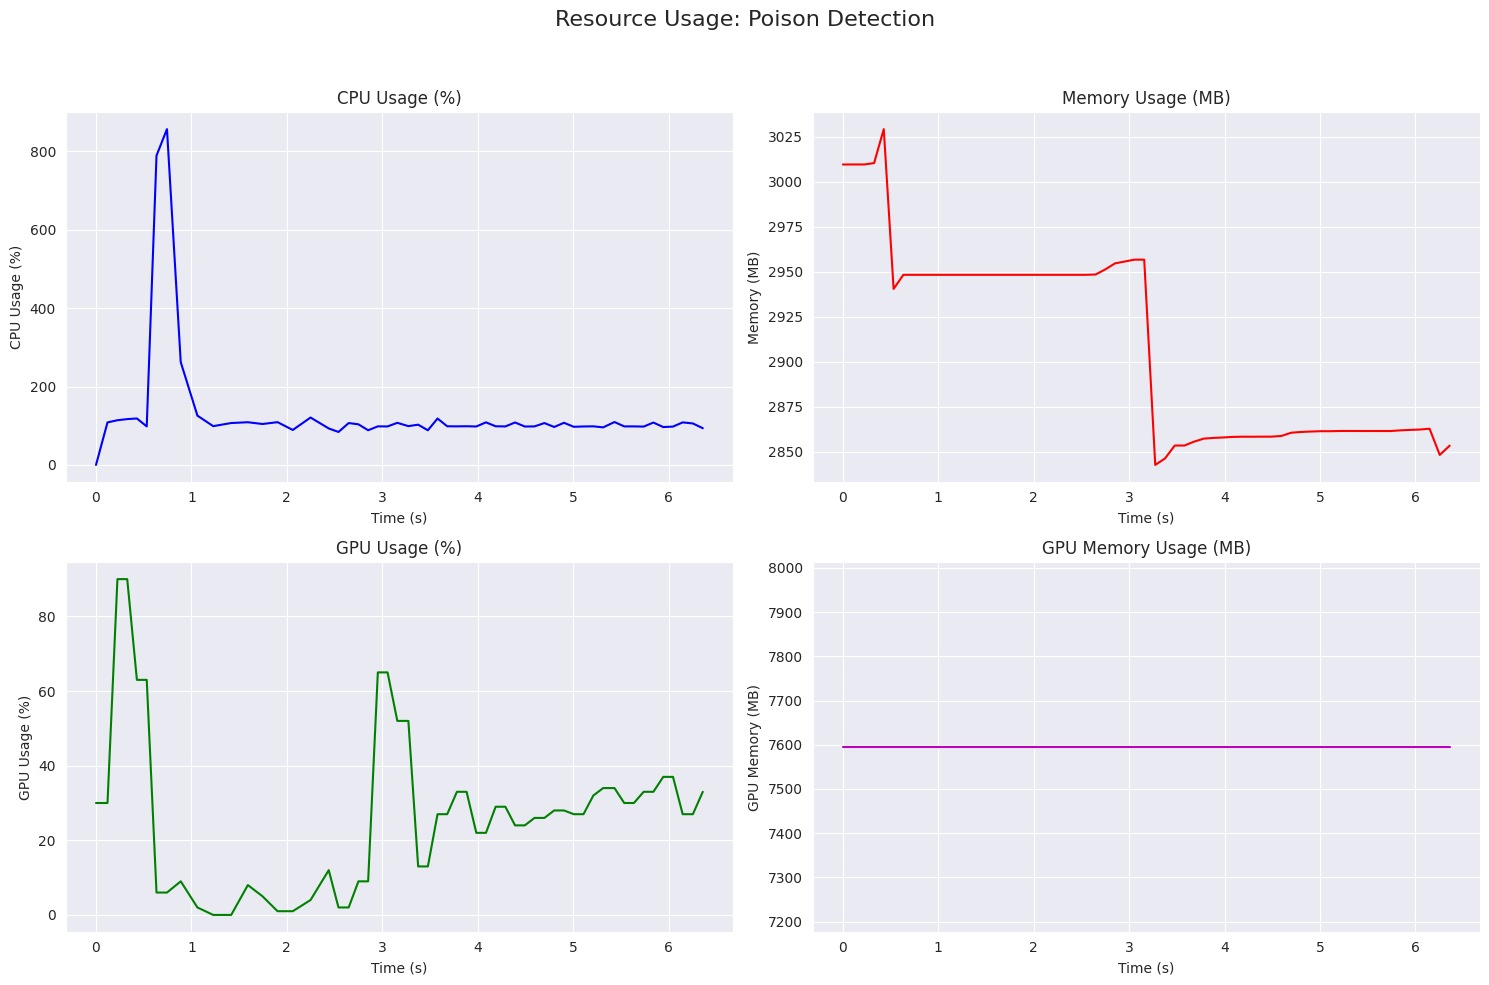

In [55]:
sample_percentage = 0.4
benign_test_indices = np.where(is_poison_test == 0)[0]
sample_size = int(sample_percentage * len(benign_test_indices))
sample_indices = np.random.choice(len(benign_test_indices), size=sample_size, replace=False)
benign_sample = benign_test_indices[sample_indices]

defence = ClusteringCentroidAnalysis(classifier, x_poisoned_test, y_poisoned_test, benign_sample, "dense_1", misclassification_threshold=0.06)

with PerformanceTimer(task_name="Poison Detection", plot=True, save_data=False) as timer_ccaud:
    report, is_clean_lst = defence.detect_poison()


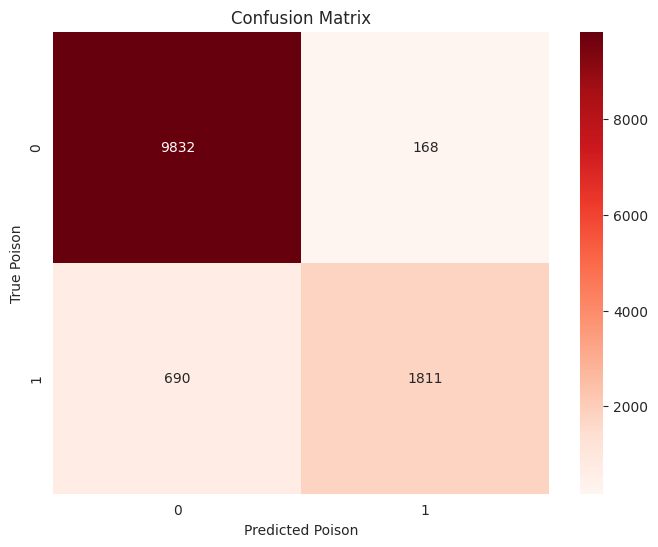

              precision    recall  f1-score   support

           0     0.9344    0.9832    0.9582     10000
           1     0.9151    0.7241    0.8085      2501

    accuracy                         0.9314     12501
   macro avg     0.9248    0.8537    0.8833     12501
weighted avg     0.9306    0.9314    0.9282     12501



In [56]:

from sklearn.metrics import confusion_matrix

is_poisoned_lst = 1 - is_clean_lst.astype('int32')
poison_confusion_matrix = confusion_matrix(is_poison_test, is_poisoned_lst)
plt.figure(figsize=(8, 6))

sns.heatmap(poison_confusion_matrix, annot=True, fmt="d", cmap="Reds")
plt.xlabel("Predicted Poison")
plt.ylabel("True Poison")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(is_poison_test, is_poisoned_lst, digits=4)
print(report)

### Evaluate Defense

In [57]:
# Evaluate method when ground truth is known:
print("------------------- Results using size metric -------------------")
is_clean = (is_poison_train == 0)
confusion_matrix = defence.evaluate_defence(is_clean[shuffled_indices])

jsonObject = json.loads(confusion_matrix)
for label in jsonObject:
    print(label)
    pprint.pprint(jsonObject[label]) 

------------------- Results using size metric -------------------
class_0
{'FalseNegative': {'denominator': 233, 'numerator': 229, 'rate': 98.28},
 'FalsePositive': {'denominator': 992, 'numerator': 12, 'rate': 1.21},
 'TrueNegative': {'denominator': 992, 'numerator': 980, 'rate': 98.79},
 'TruePositive': {'denominator': 233, 'numerator': 4, 'rate': 1.72}}
class_1
{'FalseNegative': {'denominator': 251, 'numerator': 199, 'rate': 79.28},
 'FalsePositive': {'denominator': 1168, 'numerator': 235, 'rate': 20.12},
 'TrueNegative': {'denominator': 1168, 'numerator': 933, 'rate': 79.88},
 'TruePositive': {'denominator': 251, 'numerator': 52, 'rate': 20.72}}
class_2
{'FalseNegative': {'denominator': 257, 'numerator': 205, 'rate': 79.77},
 'FalsePositive': {'denominator': 1033, 'numerator': 225, 'rate': 21.78},
 'TrueNegative': {'denominator': 1033, 'numerator': 808, 'rate': 78.22},
 'TruePositive': {'denominator': 257, 'numerator': 52, 'rate': 20.23}}
class_3
{'FalseNegative': {'denominator': 2

### Get clustering and reduce activations to 3 dimensions using PCA

In [58]:
clusters_by_class, _ = defence.cluster_activations()

defence.set_params(ndims=3)
_, red_activations_by_class = defence.cluster_activations()

AttributeError: 'ClusteringCentroidAnalysis' object has no attribute 'cluster_activations'

### Visualize activations colored by clustering

In [ ]:
c = 0
red_activations = red_activations_by_class[c]
clusters = clusters_by_class[c]
fig = plt.figure()
ax = plt.axes(projection='3d')
colors=["#0000FF", "#00FF00"]
for i, act in enumerate(red_activations):
    ax.scatter3D(act[0], act[1], act[2], color = colors[clusters[i]])

In [ ]:
def plot_class_clusters(n_class, n_clusters):
    for q in range(n_clusters):
        plt.figure(1, figsize=(25, 25))
        plt.tight_layout()
        plt.subplot(1, n_clusters, q + 1)
        plt.title("Class "+ str(n_class)+ ", Cluster " + str(q), fontsize=40)
        sprite = sprites_by_class[n_class][q]
        plt.imshow(sprite, interpolation='none')
        
sprites_by_class = defence.visualize_clusters(x_train, save=False)

# Visualize clusters for class 1
print("Clusters for class 1.")
print("Note that one of the clusters contains the poisonous data for this class.")
print("Also, legitimate number of data points are less (see relative size of digits)")
plot_class_clusters(1, 2)

In [ ]:
print("Clusters for class 5:")
plot_class_clusters(5, 2)

## Activation Defense (with exclusionary reclassification)

In [ ]:
# Here we use exclusionary reclassification, which will also relabel the data internally
defence = ActivationDefence(classifier, x_train, y_train, ex_re_threshold=1)

In [ ]:
report, is_clean_lst = defence.detect_poison(nb_clusters=2, nb_dims=10, reduce="PCA")

In [ ]:
print("Analysis completed. Report:")
pprint.pprint(report)

### Evaluate Defence

In [ ]:
# Evaluate method when ground truth is known:
print("------------------- Results using size metric -------------------")
is_clean = (is_poison_train == 0)
cm = defence.evaluate_defence(is_clean[shuffled_indices])

jsonObject = json.loads(cm)
for label in jsonObject:
    print(label)
    pprint.pprint(jsonObject[label]) 

### Get clustering and reduce activations to 3 dimensions using PCA

In [ ]:
clusters_by_class, _ = defence.cluster_activations()

defence.set_params(ndims=3)
_, red_activations_by_class = defence.cluster_activations()

### Visualize activations colored by clustering

In [ ]:
c = 0
red_activations = red_activations_by_class[c]
clusters = clusters_by_class[c]
fig = plt.figure()
ax = plt.axes(projection='3d')
colors=["#0000FF", "#00FF00"]
for i, act in enumerate(red_activations):
    ax.scatter3D(act[0], act[1], act[2], color = colors[clusters[i]])

In [ ]:
def plot_class_clusters(n_class, n_clusters):
    for q in range(n_clusters):
        plt.figure(1, figsize=(25, 25))
        plt.tight_layout()
        plt.subplot(1, n_clusters, q+1)
        plt.title("Class "+ str(n_class)+ ", Cluster " + str(q), fontsize=40)
        sprite = sprites_by_class[n_class][q]
        plt.imshow(sprite, interpolation='none')
        
sprites_by_class = defence.visualize_clusters(x_train, save=False)

# Visualize clusters for class 1
print("Clusters for class 1.")
print("Note that one of the clusters contains the poisonous data for this class.")
print("Also, legitimate number of data points are less (see relative size of digits)")
plot_class_clusters(1, 2)

In [ ]:
print("Clusters for class 5:")
plot_class_clusters(5, 2)